In [6]:
import pandas as pd
import math
import numpy as np
import tifffile as tif
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from tqdm import tqdm
import utils.analysis as analysis
import utils.denoise as denoise
from sklearn.decomposition import PCA, FastICA
import utils.analysis as analysis
%matplotlib inline

In [7]:
neuron_path = '/Users/aichah/Desktop/TLI/data/subtypeC/211104_P36_N3_R290_clahe.tif'
mask_path = '/Users/aichah/Desktop/TLI/data/subtypeC/211104_P36_N3_R290_JE_mask.tif'
entry_point = (110,250) #y,x
y,x = entry_point[0],entry_point[1]

In [8]:
neuron = tif.imread(neuron_path)
mask = tif.imread(mask_path)
neuron -= neuron.min()
neuron[mask==0] = 0
# mask = denoise.mask_image(neuron, return_mask = False ,sig = 1)

In [9]:
lifetimes = analysis.cal_lifetimes(neuron, save=False)
stable_neuron1 = analysis.stable_N(lifetimes, stab_limit=5, save=False) 

100%|██████████| 88/88 [00:05<00:00, 14.83it/s]


In [10]:
stable_neuron[stable_neuron>0] = 1
stable_neuron.sum()

NameError: name 'stable_neuron' is not defined

In [45]:
stable_neuron1[stable_neuron1>0] = 1
stable_neuron1.sum()

7907698.0

In [47]:
stable_neuron.sum()/stable_neuron1.sum()

1.3817261357224315

In [30]:
neuron[stable_neuron==0] = 0

In [16]:
image = neuron[-1].max(axis=0)

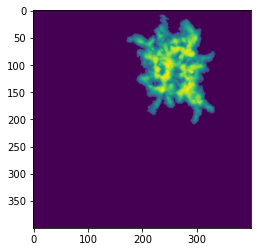

In [17]:
plt.imshow(image)

In [24]:
def rotate(origin, point, angle, direction = 'counterclockwise'):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point
    if direction == 'counterclockwise':
        qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
        qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)

    elif direction == 'clockwise':
        qx = ox + math.cos(angle) * (px - ox) + math.sin(angle) * (py - oy)
        qy = oy - math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)

    return qx, qy

def angle_between(p1,p2):
    """
    angle beteen 2 points
    """
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.rad2deg((ang1-ang2 % (2 * np.pi)))

#everything as one...
def metric_dump(image,entry_point):
    """

    """
    y, x = np.nonzero(image)
    x = x - entry_point[1]
    y = y - entry_point[0]
    coords = np.vstack([x, y])
    cov = np.cov(coords)
    evals, evecs = np.linalg.eig(cov)
    sort_indices = np.argsort(evals)[::-1]
    x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
    x_v2, y_v2 = evecs[:, sort_indices[1]]
    scale = 20
    plt.plot(x, y, 'k.',alpha=0.2)
    plt.plot([x_v1*-scale*2, x_v1*scale*2],
            [y_v1*-scale*2, y_v1*scale*2], color='red')
    plt.plot([x_v2*-scale, x_v2*scale],
            [y_v2*-scale, y_v2*scale], color='blue')
    # plt.plot(x, y, 'k.')
    plt.axis('equal')
    plt.gca().invert_yaxis()  # Match the image system with origin at top left
    plt.show()
    
    
    # # # get coords of pixels above threshold
    # # coords = np.array(np.where(image >0))
    # y_img, x_img = np.nonzero(image)

    # # # subtract entry point and do some organising
    # y_img = y_img - entry_point[0]
    # x_img = x_img - entry_point[1]

    # coords = np.vstack([x_img,y_img])

    # # coords = (np.argwhere(image) - entry_point).T

    # # rebase image

    # # find the covariance matrix:
    # cov_mat = np.cov(coords)

    # # get eigen vectors and values
    # evals, evecs = np.linalg.eig(cov_mat)

    # # get the order of the eigen values and sort the eigenvectors
    # sort_indices = np.argsort(evals)[::-1]
    # x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
    # x_v2, y_v2 = evecs[:, sort_indices[1]]

    # calculate the angle of rotation of the eigenvectors relative to the original coordinate space and get the rotation matrix
    theta = np.arctan((x_v1)/(y_v1))  
    rotation_mat = np.matrix([[np.cos(theta), -np.sin(theta)],
                        [np.sin(theta), np.cos(theta)]])

    inv_rot_mat = np.linalg.inv(rotation_mat)

    # rotate the original coordinates
    rotated_coords = rotation_mat * coords

    # plot the transformed blob
    x_transformed, y_transformed = rotated_coords.A

    # we want the minimum and maximum values along each axis
    x_max = np.max(x_transformed)
    x_min = np.min(x_transformed)
    y_max = np.max(y_transformed)
    y_min = np.min(y_transformed)

    # the fraction of pixels in each direction
    frac_x_pos = len(x_transformed[x_transformed>0])/len(x_transformed)
    frac_x_neg = 1 - frac_x_pos
    frac_y_pos = len(y_transformed[y_transformed>0])/len(y_transformed)
    frac_y_neg = 1 - frac_y_pos


    # signed_x = np.sign(x_transformed)
    # signed_y = np.sign(y_transformed)
    # frac_x_pos = len(signed_x[signed_x == 1]) /len(x_transformed)
    # frac_x_neg = 1 - frac_x_pos
    # frac_y_pos = len(signed_y[signed_y == 1]) /len(y_transformed)
    # frac_y_neg = 1 - frac_y_pos

    # The difference
    diff_x = abs(frac_x_pos - frac_x_neg)
    diff_y = abs(frac_y_pos - frac_y_neg)

    # then the difference times the fraction in that direction
    x_pos = diff_x * frac_x_pos
    x_neg = diff_x * frac_x_neg
    y_pos = diff_y * frac_y_pos
    y_neg = diff_y * frac_y_neg


    # and finally, multiply by the scalar value from the first point. 
    final_x_pos = x_max * x_pos
    final_x_neg = x_min * x_neg
    final_y_pos = y_max * y_pos
    final_y_neg = y_min * y_neg

    ## sort out the vectors - we have the points, and the origin is [0,0], so rotate the second point by -theta degrees

    x_pos_final = rotate(origin = [0,0], point = [final_x_pos,0], angle = theta, direction = 'clockwise')
    x_neg_final = rotate(origin = [0,0], point = [final_x_neg,0], angle = theta, direction = 'clockwise')
    y_pos_final = rotate(origin = [0,0], point = [0,final_y_pos], angle = theta, direction = 'clockwise')
    y_neg_final = rotate(origin = [0,0], point = [0,final_y_neg], angle = theta, direction = 'clockwise')

    # get angle of each vector
    x_pos_angle = angle_between([0,0],x_pos_final)
    x_neg_angle = angle_between([0,0], x_neg_final)
    y_pos_angle = angle_between([0,0], y_pos_final)
    y_neg_angle = angle_between([0,0], y_neg_final)

    df = pd.DataFrame.from_dict({'axis':['x_positive','x_negative','y_positive','y_negative'],
                                'Fraction_weight':[x_pos,x_neg,y_pos,y_neg],
                                'Pixel_scale':[x_max,x_min,y_max,y_min],
                                'Angle':[x_pos_angle,x_neg_angle,y_pos_angle,y_neg_angle],
                                'xy': [x_pos_final,x_neg_final,y_pos_final,y_neg_final]})

    asymmetry = (diff_x + diff_y)/2


    # x_transformed, y_transformed = transformed_mat.A
    # plt.plot(x_transformed, y_transformed, 'g.',alpha=0.1)
    # plt.axis('equal')
    # plt.gca().invert_yaxis()  # Match the image system with origin at top left
    # plt.show()

    return df,asymmetry

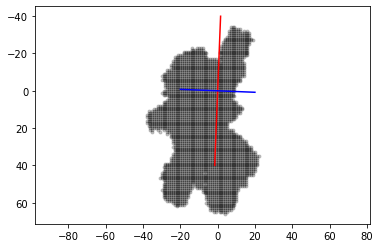

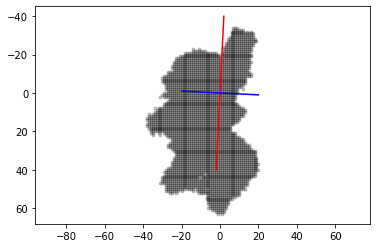

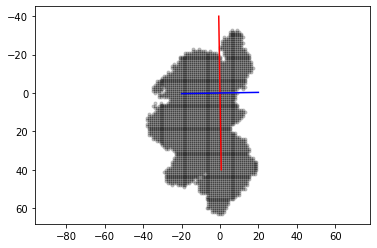

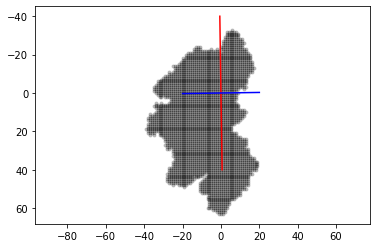

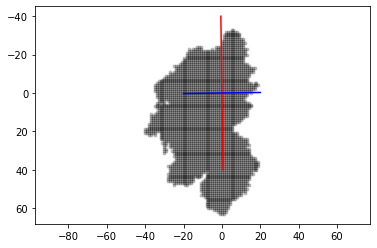

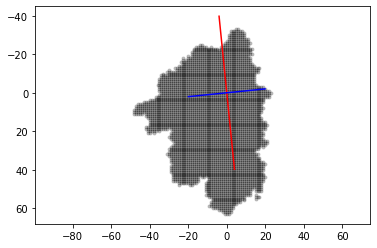

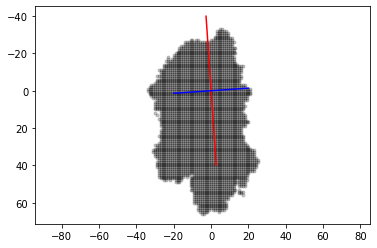

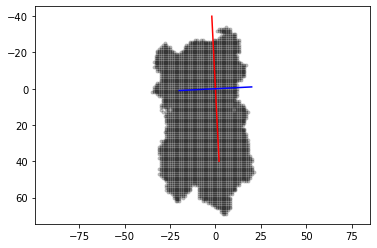

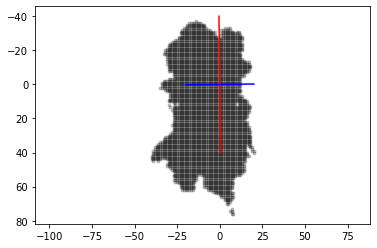

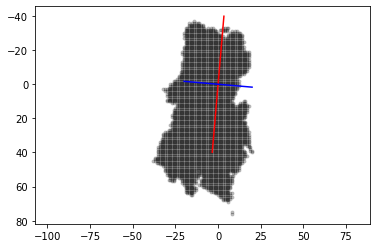

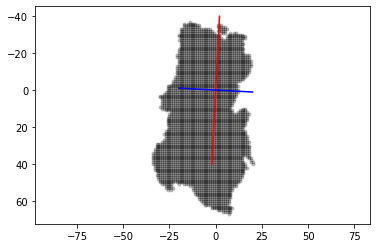

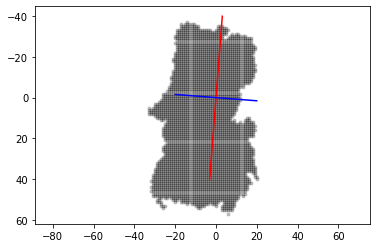

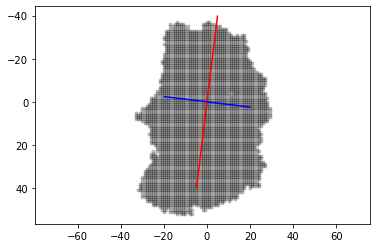

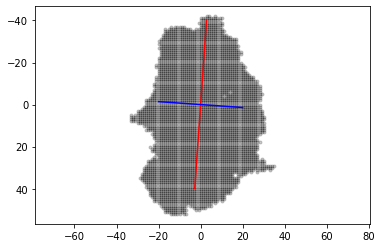

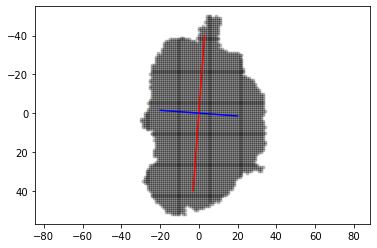

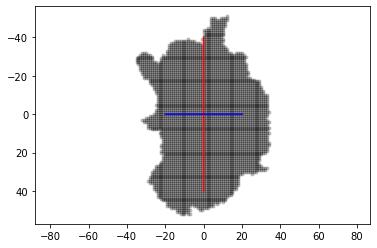

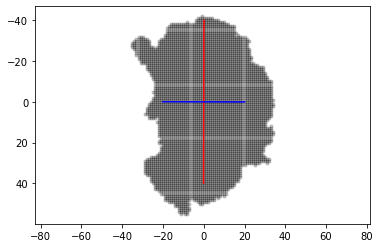

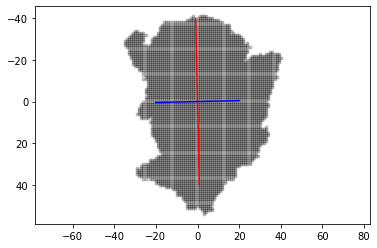

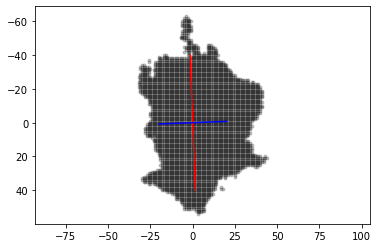

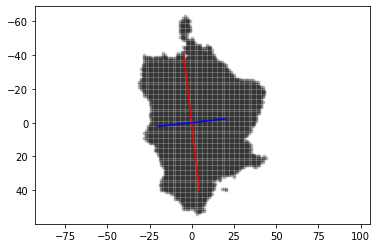

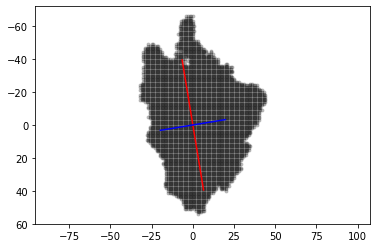

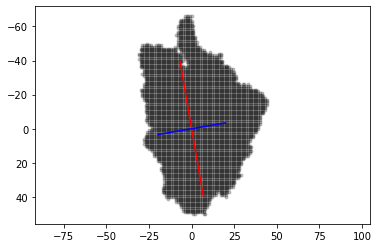

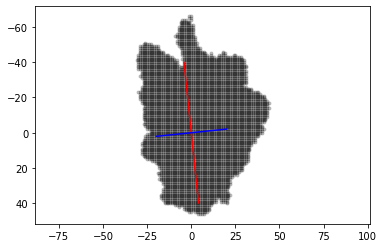

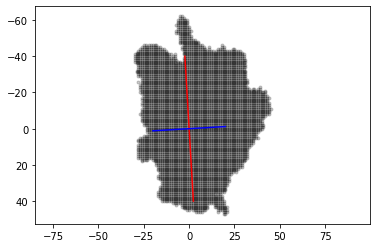

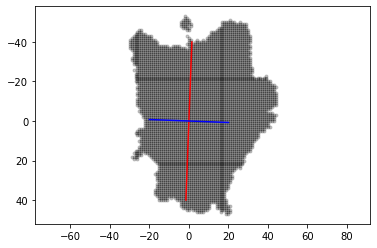

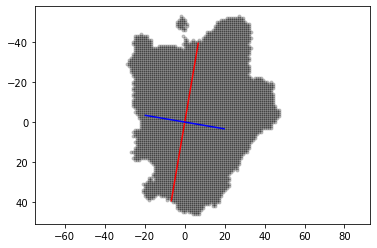

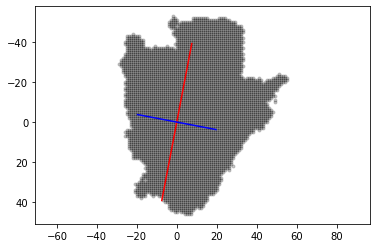

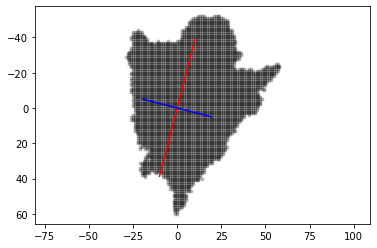

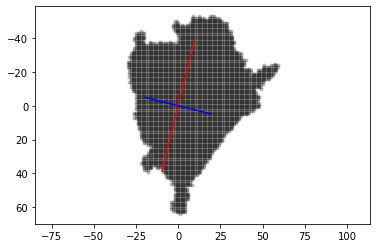

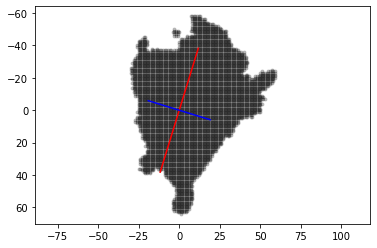

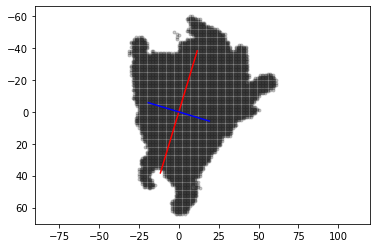

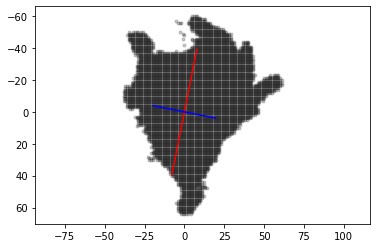

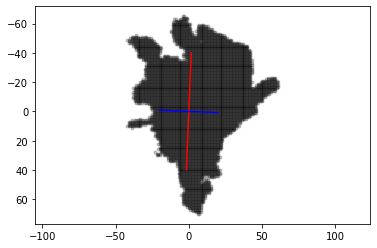

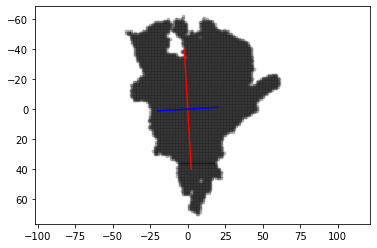

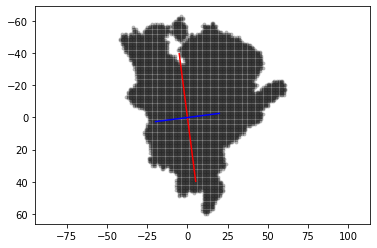

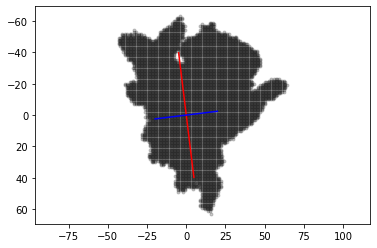

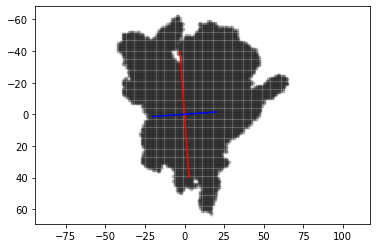

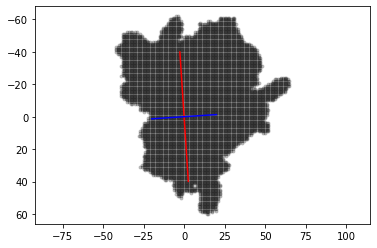

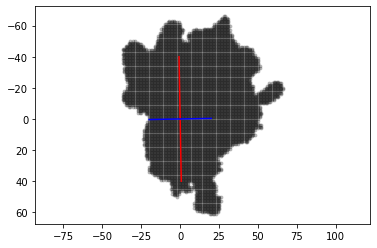

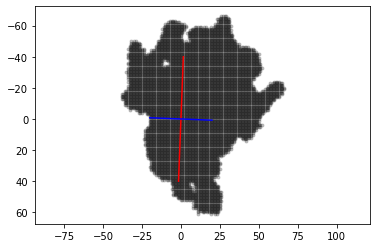

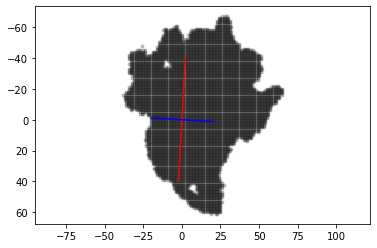

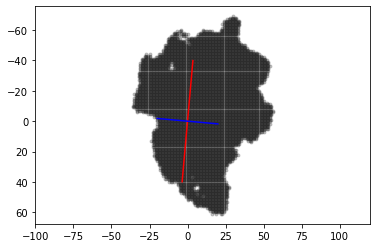

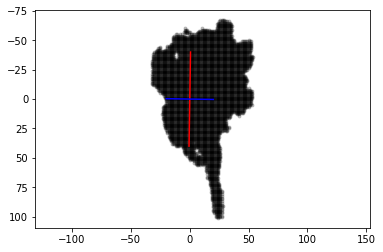

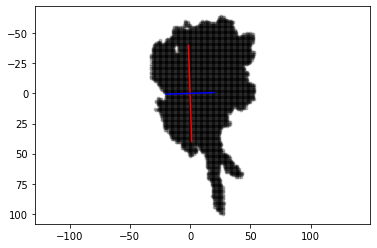

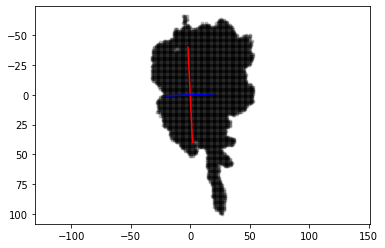

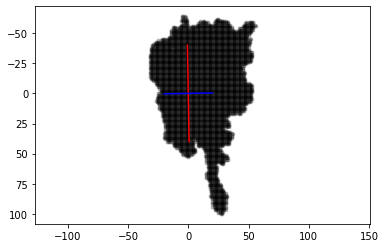

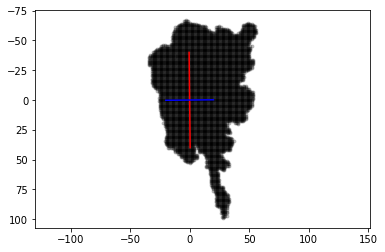

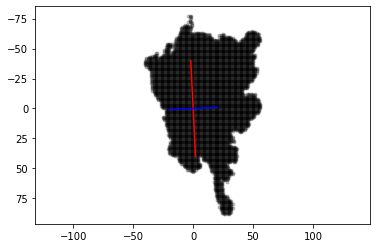

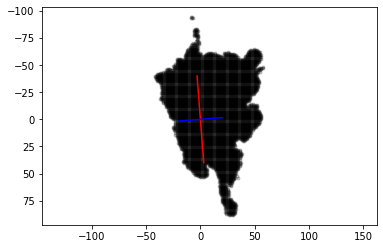

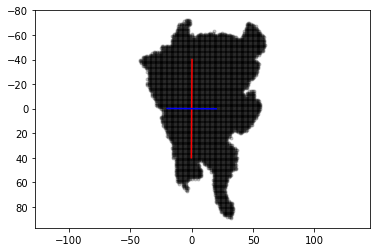

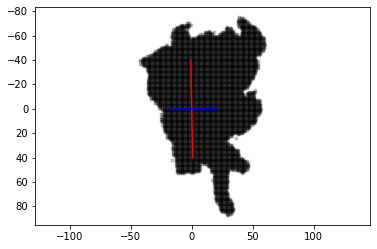

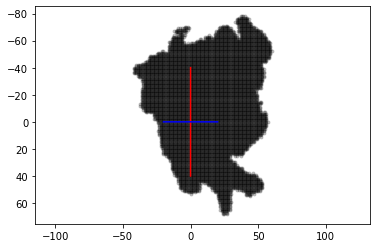

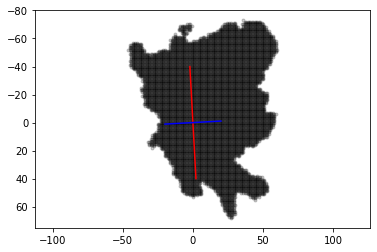

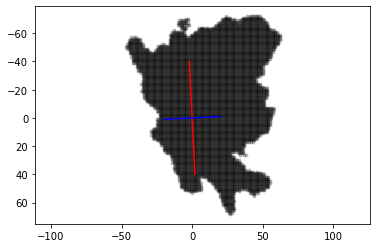

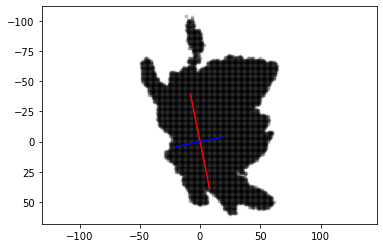

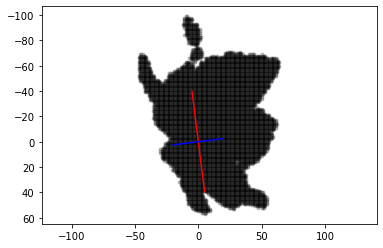

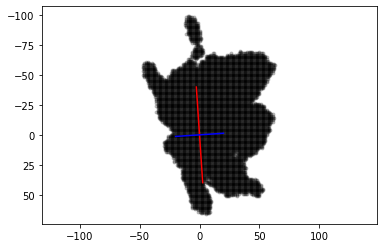

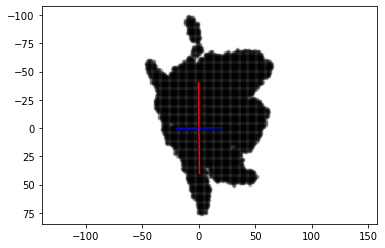

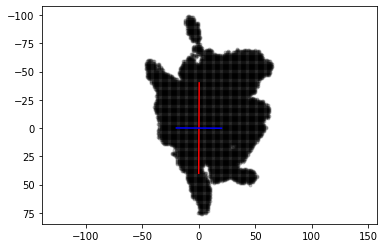

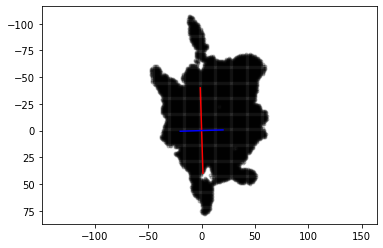

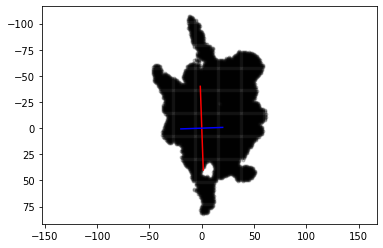

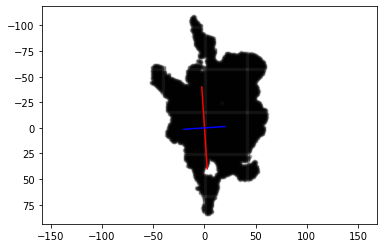

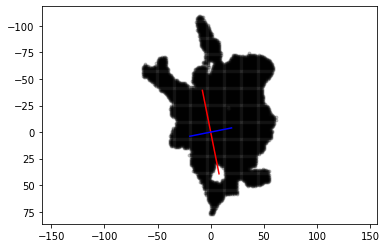

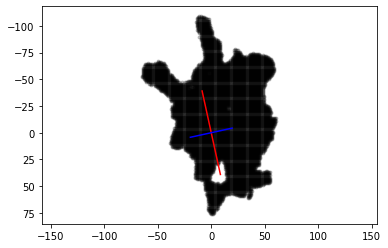

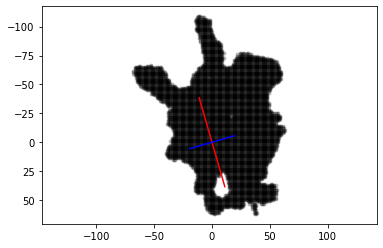

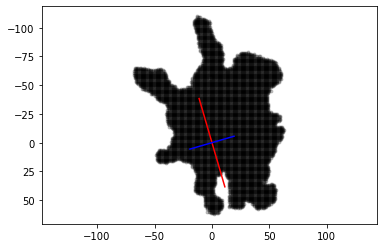

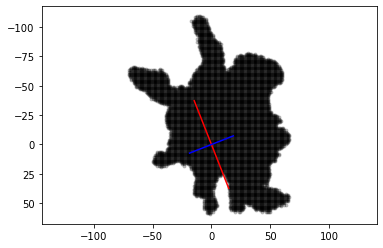

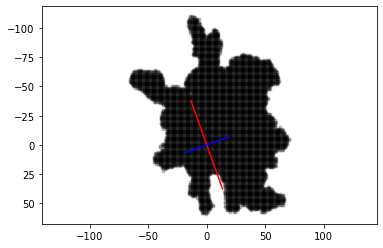

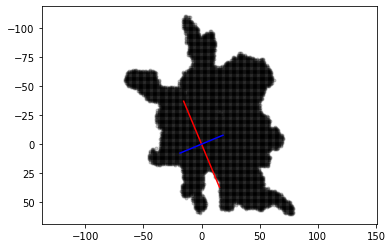

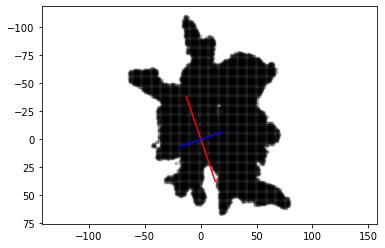

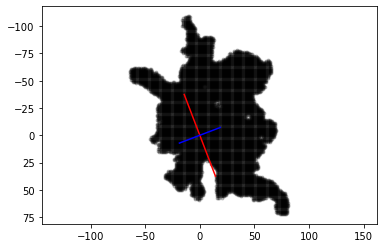

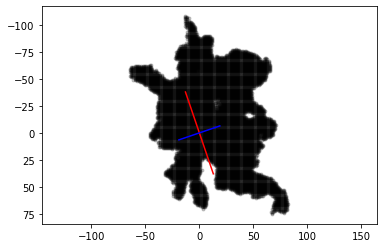

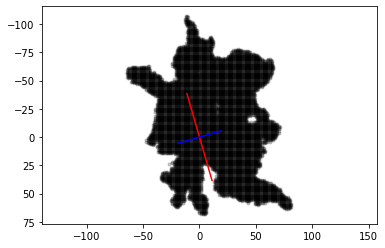

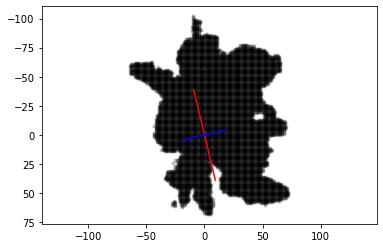

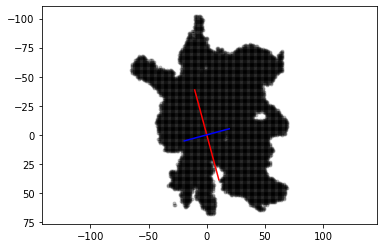

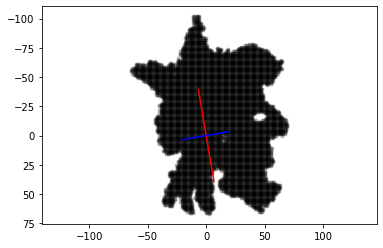

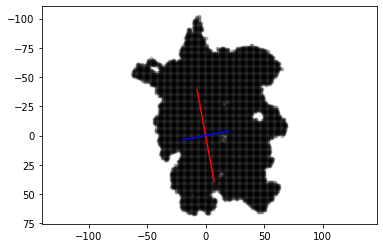

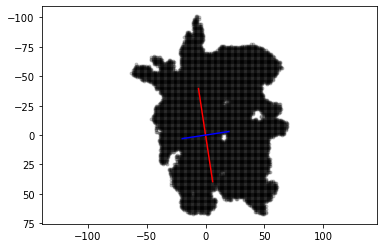

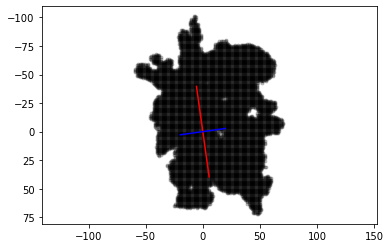

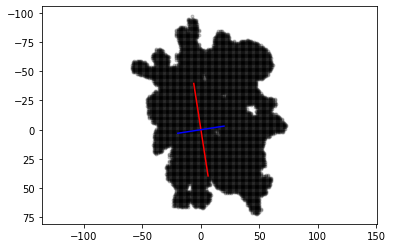

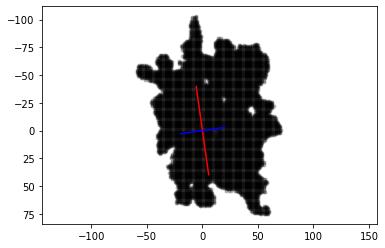

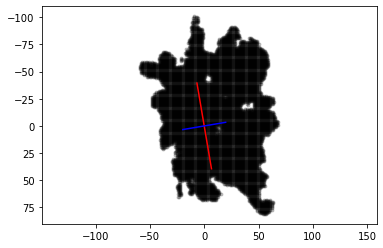

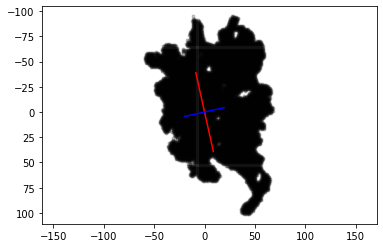

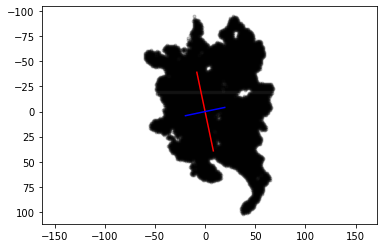

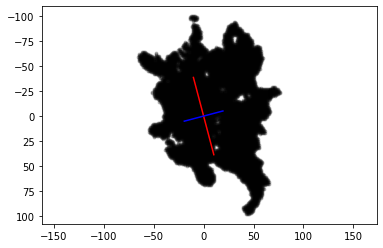

In [32]:
asymetries = []
axis_final = {}
for t, stack in enumerate(neuron[4:]):
    image = stack.max(axis=0)
    result =  metric_dump(image,entry_point)
    asymetries.append(result[1])
    axis_final[t] = result[0]

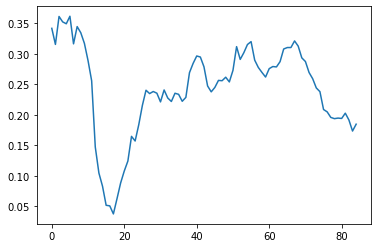

In [33]:
plt.plot(asymetries)

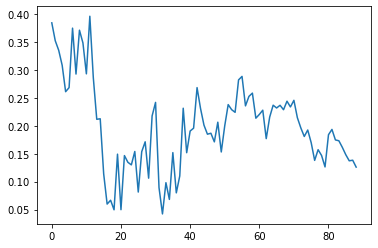

In [21]:
plt.plot(asymetries) # all pixels

In [22]:
axis_final[0]

,axis,Fraction_weight,Pixel_scale,Angle,xy
0,x_positive,0.088375,39.286789,-357.488634,"(3.4686260976444556, -0.1521329036414841)"
1,x_negative,0.140977,-53.045496,-177.488634,"(-7.471012186530038, 0.32767636092272495)"
2,y_positive,0.415095,75.409959,-87.488634,"(1.3715916440103755, 31.27225247036007)"
3,y_negative,0.124227,-34.747296,-267.488634,"(-0.18914068576428122, -4.31240253137099)"


In [23]:
axis_final[1]

,axis,Fraction_weight,Pixel_scale,Angle,xy
0,x_positive,0.103289,36.393505,-351.04636,"(3.713250341425469, -0.5850416018464847)"
1,x_negative,0.188332,-50.940708,-171.04636,"(-9.476876405333156, 1.4931303959831737)"
2,y_positive,0.291821,82.036240,-81.04636,"(3.725893436516596, 23.648190199798005)"
3,y_negative,0.121219,-48.240906,-261.04636,"(-0.9101103802342255, -5.7764570407872915)"


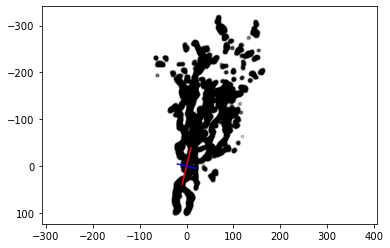

0.44993061979648474


,axis,Fraction_weight,Pixel_scale,Angle,xy
0,x_positive,0.094430,111.157377,-13.55319,"(10.204305737918217, 2.45985843968302)"
1,x_negative,0.068035,-120.709464,-193.55319,"(-7.983793521696196, -1.9245799155207948)"
2,y_positive,0.096822,104.046130,-103.55319,"(-2.3608005724134773, 9.793380967997399)"
3,y_negative,0.640574,-335.078708,-283.55319,"(50.30110769268061, -208.66561813947547)"


In [36]:
neuron_path = '/Users/aichah/Desktop/TLI/data/300322_B4O2D1_layer4_x86_y350.tif'
# mask_path = '/Users/aichah/Desktop/TLI/data/subtypeC/211104_P36_N3_R290_JE_mask.tif'
entry_point = (350,86) #y,x
y,x = entry_point[0],entry_point[1]
neuron = tif.imread(neuron_path)
# mask = tif.imread(mask_path)
neuron -= neuron.min()
# neuron[mask==0] = 0
mask = denoise.mask_image(neuron, return_mask = False ,sig = 1)
neuron[mask==0] = 0
image = neuron
result =  metric_dump(image,entry_point)
print(result[1])
result[0]

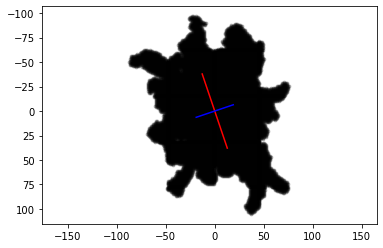

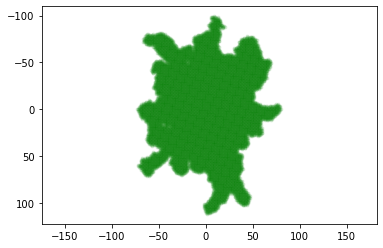

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
# import skimage.filter


img = image.copy()
y, x = np.nonzero(img)
x = x - entry_point[1]
y = y - entry_point[0]
coords = np.vstack([x, y])
cov = np.cov(coords)
evals, evecs = np.linalg.eig(cov)
sort_indices = np.argsort(evals)[::-1]
x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
x_v2, y_v2 = evecs[:, sort_indices[1]]
scale = 20
plt.plot(x, y, 'k.',alpha=0.2)
plt.plot([x_v1*-scale*2, x_v1*scale*2],
         [y_v1*-scale*2, y_v1*scale*2], color='red')
plt.plot([x_v2*-scale, x_v2*scale],
         [y_v2*-scale, y_v2*scale], color='blue')
# plt.plot(x, y, 'k.')
plt.axis('equal')
plt.gca().invert_yaxis()  # Match the image system with origin at top left
plt.show()


theta = np.arctan((x_v1)/(y_v1))  
rotation_mat = np.matrix([[np.cos(theta), -np.sin(theta)],
                      [np.sin(theta), np.cos(theta)]])
transformed_mat = rotation_mat * coords
# plot the transformed blob
x_transformed, y_transformed = transformed_mat.A
plt.plot(x_transformed, y_transformed, 'g.',alpha=0.1)
# plt.plot(x, y, 'k.',alpha=0.2)
# plt.plot([x_v1*-scale*2, x_v1*scale*2],
#          [y_v1*-scale*2, y_v1*scale*2], color='red')
# plt.plot([x_v2*-scale, x_v2*scale],
#          [y_v2*-scale, y_v2*scale], color='blue')
# plt.plot(x, y, 'k.')
plt.axis('equal')
plt.gca().invert_yaxis()  # Match the image system with origin at top left
plt.show()

# y_img, x_img = np.nonzero(image)

# # # subtract entry point and do some organising
# y_img = y_img - entry_point[0]
# x_img = x_img - entry_point[1]

# coords = np.vstack([x_img,y_img])

# # coords = (np.argwhere(image) - entry_point).T

# # rebase image

# # find the covariance matrix:
# cov_mat = np.cov(coords)

# # get eigen vectors and values
# evals, evecs = np.linalg.eig(cov_mat)

# # get the order of the eigen values and sort the eigenvectors
# sort_indices = np.argsort(evals)[::-1]
# x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
# x_v2, y_v2 = evecs[:, sort_indices[1]]
# scale = 20
# plt.plot([x_v1*-scale*2, x_v1*scale*2],
#          [y_v1*-scale*2, y_v1*scale*2], color='red')
# plt.plot([x_v2*-scale, x_v2*scale],
#          [y_v2*-scale, y_v2*scale], color='blue')
# plt.plot(x, y, 'k.')
# plt.axis('equal')
# plt.gca().invert_yaxis()  # Match the image system with origin at top left
# plt.show()

In [52]:
x_transformed.min(),x_transformed.max()

(-73.01923134002291, 80.03630684255337)

In [61]:
signed_x = np.sign(x_transformed)
# signed_y = np.sign(y_transformed)
frac_x_pos = len(signed_x[signed_x == 1]) /len(x_transformed)
frac_x_neg = 1 - frac_x_pos
frac_x_neg, frac_x_pos

(0.4760600353820693, 0.5239399646179307)

In [62]:
frac_x_pos = len(x_transformed[x_transformed>0])/len(x_transformed)
frac_x_neg = 1 - frac_x_pos
# len(x_transformed[x_transformed<0])/len(x_transformed)
frac_x_neg, frac_x_pos

(0.4760600353820693, 0.5239399646179307)

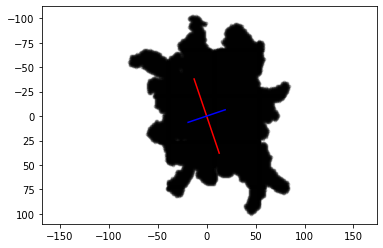

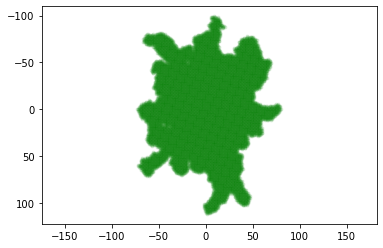

In [78]:
result =  metric_dump(image,entry_point)

In [32]:
result[1:]

(0.12600582092107515,
 -0.3204375996023006,
 -0.947269626221128,
 -0.947269626221128,
 0.3204375996023006)

In [116]:
result[0]

,axis,Fraction_weight,Pixel_scale,Angle,xy
0,x_positive,0.126530,89.504214,-341.310609,"(10.727834010511772, -3.628957673829024)"
1,x_negative,0.082737,-63.551324,-161.310609,"(-4.9808112234329025, 1.6848837419985663)"
2,y_positive,0.020458,109.146655,-71.310609,"(0.7155260299802804, 2.115220173325882)"
3,y_negative,0.022285,-101.428066,-251.310609,"(-0.7243068633142039, -2.1411778534497476)"


In [113]:
test = image.copy()
test[y-1:y+1,x-1:x+1] = 5

In [66]:
coor = result[0].xy
px_1 = result[0].xy[0]
px_2 = result[0].xy[1]
px_3 = result[0].xy[2]
px_4 = result[0].xy[3]


In [67]:
px_1 , px_2, px_3, px_4

((41.90064244967543, 7.870275954903646),
 (-4.451715927980871, -0.8361741199584116),
 (-0.43026571824267423, 2.2906960469672377),
 (0.3095368064465977, -1.6479461617673437))

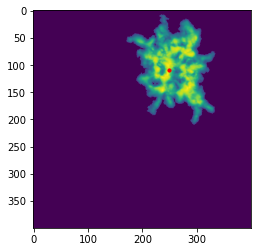

In [115]:
plt.imshow(test)
plt.scatter(x,y,c='red',s=10)
# plt.plot((x,px_1[0]),(y,px_1[1]))
# plt.plot((x,px_2[0]),(y,px_2[1]))
# plt.plot((x,px_3[0]),(y,px_3[1]))
# plt.plot((x,px_4[0]),(y,px_4[1]))

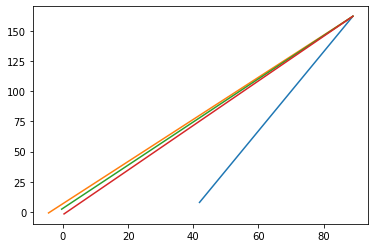

In [69]:
plt.plot((x,px_1[0]),(y,px_1[1]))
plt.plot((x,px_2[0]),(y,px_2[1]))
plt.plot((x,px_3[0]),(y,px_3[1]))
plt.plot((x,px_4[0]),(y,px_4[1]))

In [70]:
x,y

(89, 162)

In [132]:
coords = (np.argwhere(image) - entry_point)

# rebase image

# find the covariance matrix:
cov_mat = np.cov(coords)

# get eigen vectors and values
evals, evecs = np.linalg.eig(cov_mat)

In [131]:
coords.shape

(2, 17523)

In [7]:
test = np.zeros_like(image)


def Covariance(x, y):
    xbar, ybar = x.mean(), y.mean()
    result = np.sum((x - xbar)*(y - ybar))/(len(x) - 1)
    return result, xbar, ybar
Covariance(image, test)

(0.0, 206.31869375, 0.0)

In [31]:
test_x = [1,1,4,1]
test_y = [2,2,8,2]
sample = np.array(list(zip(test_x,test_y)))
print(sample.shape)
cov_mat = np.cov(sample)
evals, evecs = np.linalg.eig(cov_mat)
sort_indices = np.argsort(evals)[::-1]
# x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
# x_v2, y_v2 = evecs[:, sort_indices[1]]

(4, 2)


In [28]:
x_v1, y_v1, x_v2, y_v2

(-0.4472135954999579,
 -0.8944271909999159,
 -0.8944271909999159,
 0.4472135954999579)

In [32]:
sort_indices

array([0, 2, 3, 1])

In [37]:
evecs.shape

(4, 4)

In [35]:
evals.max()

9.499999999999996

In [36]:
evals

array([ 9.50000000e+00, -4.32244696e-16,  4.19082356e-31,  0.00000000e+00])

In [39]:
#importing the dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
 
digits = load_digits()
data = digits.data
data.shape

(1797, 64)

In [40]:
data

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [45]:
import numpy as np
from math import atan2, cos, sin, sqrt, pi
# from google.colab.patches import cv2_imshow
import cv2
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, bw = cv2.threshold(image, 50, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
contours, _ = cv2.findContours(bw, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

error: OpenCV(4.5.3) /private/var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/pip-req-build-vy_omupv/opencv/modules/imgproc/src/contours.cpp:197: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


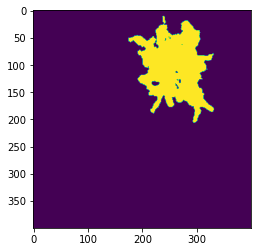

In [46]:
plt.imshow(bw)

In [ ]:
def get_orientation(pts, img):
    sz = len(pts)
    data_pts = np.empty((sz, 2), dtype=np.float64)
    for i in range(data_pts.shape[0]):
        data_pts[i,0] = pts[i,0,0]
        data_pts[i,1] = pts[i,0,1]
    # Perform PCA analysis
    mean = np.empty((0))
    mean, eigenvectors, eigenvalues = cv2.PCACompute2(data_pts, mean)
    # Store the center of the object
    cntr = (int(mean[0,0]), int(mean[0,1]))
    cv2.circle(img, cntr, 3, (255, 0, 255), 2)
    p1 = (cntr[0] + 0.02 * eigenvectors[0,0] * eigenvalues[0,0], cntr[1] + 0.02 *  eigenvectors[0,1] * eigenvalues[0,0])
    p2 = (cntr[0] - 0.02 * eigenvectors[1,0] * eigenvalues[1,0], cntr[1] - 0.02 * eigenvectors[1,1] * eigenvalues[1,0])
    draw_axis(img, cntr, p1, (0, 150, 0), 1)
    draw_axis(img, cntr, p2, (200, 150, 0), 5)
    angle = atan2(eigenvectors[0,1], eigenvectors[0,0]) # orientation in radians
    return angle
def draw_axis(img, p_, q_, colour, scale):
    p = list(p_)
    q = list(q_)
    angle = atan2(p[1] - q[1], p[0] - q[0]) # angle in radians
    hypotenuse = sqrt((p[1] - q[1]) * (p[1] - q[1]) + (p[0] - q[0]) * (p[0] - q[0]))
    # Here we lengthen the arrow by a factor of scale
    q[0] = p[0] - scale * hypotenuse * cos(angle)
    q[1] = p[1] - scale * hypotenuse * sin(angle)
    cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), colour, 1, cv2.LINE_AA)
    # create the arrow hooks
    p[0] = q[0] + 9 * cos(angle + pi / 4)
    p[1] = q[1] + 9 * sin(angle + pi / 4)
    cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), colour, 1, cv2.LINE_AA)
    p[0] = q[0] + 9 * cos(angle - pi / 4)
    p[1] = q[1] + 9 * sin(angle - pi / 4)
    cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), colour, 1, cv2.LINE_AA)

In [7]:
from __future__ import print_function
from __future__ import division
import cv2 as cv
import numpy as np
import argparse
from math import atan2, cos, sin, sqrt, pi
def drawAxis(img, p_, q_, colour, scale):
    p = list(p_)
    q = list(q_)
    
    angle = atan2(p[1] - q[1], p[0] - q[0]) # angle in radians
    hypotenuse = sqrt((p[1] - q[1]) * (p[1] - q[1]) + (p[0] - q[0]) * (p[0] - q[0]))
    # Here we lengthen the arrow by a factor of scale
    q[0] = p[0] - scale * hypotenuse * cos(angle)
    q[1] = p[1] - scale * hypotenuse * sin(angle)
    cv.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), colour, 1, cv.LINE_AA)
    # create the arrow hooks
    p[0] = q[0] + 9 * cos(angle + pi / 4)
    p[1] = q[1] + 9 * sin(angle + pi / 4)
    cv.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), colour, 1, cv.LINE_AA)
    p[0] = q[0] + 9 * cos(angle - pi / 4)
    p[1] = q[1] + 9 * sin(angle - pi / 4)
    cv.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), colour, 1, cv.LINE_AA)
    
def getOrientation(pts, img):
    
    sz = len(pts)
    data_pts = np.empty((sz, 2), dtype=np.float64)
    for i in range(data_pts.shape[0]):
        data_pts[i,0] = pts[i,0,0]
        data_pts[i,1] = pts[i,0,1]
    # Perform PCA analysis
    mean = np.empty((0))
    mean, eigenvectors, eigenvalues = cv.PCACompute2(data_pts, mean)
    # Store the center of the object
    cntr = (int(mean[0,0]), int(mean[0,1]))
    
    
    cv.circle(img, cntr, 3, (255, 0, 255), 2)
    p1 = (cntr[0] + 0.02 * eigenvectors[0,0] * eigenvalues[0,0], cntr[1] + 0.02 * eigenvectors[0,1] * eigenvalues[0,0])
    p2 = (cntr[0] - 0.02 * eigenvectors[1,0] * eigenvalues[1,0], cntr[1] - 0.02 * eigenvectors[1,1] * eigenvalues[1,0])
    drawAxis(img, cntr, p1, (0, 255, 0), 1)
    drawAxis(img, cntr, p2, (255, 255, 0), 5)
    angle = atan2(eigenvectors[0,1], eigenvectors[0,0]) # orientation in radians
    
    return angle
parser = argparse.ArgumentParser(description='Code for Introduction to Principal Component Analysis (PCA) tutorial.\
                                              This program demonstrates how to use OpenCV PCA to extract the orientation of an object.')
parser.add_argument('--input', help='Path to input image.', default='pca_test1.jpg')
args = parser.parse_args()
src = cv.imread(cv.samples.findFile(args.input))
# Check if image is loaded successfully
if src is None:
    print('Could not open or find the image: ', args.input)
    exit(0)
cv.imshow('src', src)
# Convert image to grayscale
gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
# Convert image to binary
_, bw = cv.threshold(gray, 50, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)
contours, _ = cv.findContours(bw, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
for i, c in enumerate(contours):
    # Calculate the area of each contour
    area = cv.contourArea(c)
    # Ignore contours that are too small or too large
    if area < 1e2 or 1e5 < area:
        continue
    # Draw each contour only for visualisation purposes
    cv.drawContours(src, contours, i, (0, 0, 255), 2)
    # Find the orientation of each shape
    getOrientation(c, src)
cv.imshow('output', src)
cv.waitKey()

usage: ipykernel_launcher.py [-h] [--input INPUT]
ipykernel_launcher.py: error: unrecognized arguments: --ip=127.0.0.1 --stdin=9185 --control=9183 --hb=9182 --Session.signature_scheme="hmac-sha256" --Session.key=b"afe3cde9-8676-4592-84f8-935fb5b892bf" --shell=9184 --transport="tcp" --iopub=9186 --f=/Users/aichah/Library/Jupyter/runtime/kernel-v2-28320Dc9DHrKqq1jw.json


SystemExit: 2

/Users/aichah/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [8]:
import argparse
import numpy as np
from math import atan2, cos, sin, sqrt, pi
# from google.colab.patches import cv2_imshow
import cv2 as cv
# Load image
src = cv.imread(cv.samples.findFile('/Users/aichah/Desktop/TLI/data/TLI_CTRL_P68_B1.1.png'))
# Check if image is loaded successfully
if src is None:
    print('Could not open or find the image: ', args.input)
    exit(0)
cv.imshow('src', src)
# Convert image to grayscale
gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
# Convert image to binary
_, bw = cv.threshold(gray, 50, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)

In [9]:
# Find all the contours in the thresholded image
contours, _ = cv.findContours(bw, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
for i, c in enumerate(contours):
    # Calculate the area of each contour
    area = cv.contourArea(c)
    # Ignore contours that are too small or too large
    if area < 1e2 or 1e5 < area:
        continue
    # Draw each contour only for visualisation purposes
    cv.drawContours(src, contours, i, (0, 0, 255), 2)
    # Find the orientation of each shape
    getOrientation(c, src)

In [10]:
# Construct a buffer used by the pca analysis
sz = len(pts)
data_pts = np.empty((sz, 2), dtype=np.float64)
for i in range(data_pts.shape[0]):
    data_pts[i,0] = pts[i,0,0]
    data_pts[i,1] = pts[i,0,1]
# Perform PCA analysis
mean = np.empty((0))
mean, eigenvectors, eigenvalues = cv.PCACompute2(data_pts, mean)
# Store the center of the object
cntr = (int(mean[0,0]), int(mean[0,1]))

NameError: name 'pts' is not defined

In [21]:
import numpy as np
# to compute angles
from math import atan2, cos, sin, sqrt, pi
# from google.colab.patches import cv2_imshow
import cv2
src = cv2.imread('/Users/aichah/Desktop/TLI/data/test_cv.jpg')
# convert to grayscale
gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
# convert img into binary
_, bw = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
# calculating Contours
contours, _ = cv2.findContours(bw, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

In [20]:
len(contours[0])

528

In [10]:
pts = np.argwhere(bw)

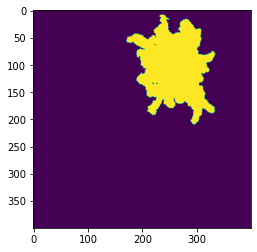

In [11]:
plt.imshow(bw)

In [12]:
def get_orientation(pts, img):
    sz = len(pts)
    data_pts = np.empty((sz, 2), dtype=np.float64)
    for i in range(data_pts.shape[0]):
        data_pts[i,0] = pts[i,0,0]
        data_pts[i,1] = pts[i,0,1]
    # Perform PCA analysis
    mean = np.empty((0))
    mean, eigenvectors, eigenvalues = cv2.PCACompute2(data_pts, mean)
    # Store the center of the object
    cntr = (int(mean[0,0]), int(mean[0,1]))
    cv2.circle(img, cntr, 3, (255, 0, 255), 2)
    p1 = (cntr[0] + 0.02 * eigenvectors[0,0] * eigenvalues[0,0], cntr[1] + 0.02 *  eigenvectors[0,1] * eigenvalues[0,0])
    p2 = (cntr[0] - 0.02 * eigenvectors[1,0] * eigenvalues[1,0], cntr[1] - 0.02 * eigenvectors[1,1] * eigenvalues[1,0])
    draw_axis(img, cntr, p1, (0, 150, 0), 1)
    draw_axis(img, cntr, p2, (200, 150, 0), 5)
    angle = atan2(eigenvectors[0,1], eigenvectors[0,0]) # orientation in radians
    return angle
def draw_axis(img, p_, q_, colour, scale):
    p = list(p_)
    q = list(q_)
    angle = atan2(p[1] - q[1], p[0] - q[0]) # angle in radians
    hypotenuse = sqrt((p[1] - q[1]) * (p[1] - q[1]) + (p[0] - q[0]) * (p[0] - q[0]))
    # Here we lengthen the arrow by a factor of scale
    q[0] = p[0] - scale * hypotenuse * cos(angle)
    q[1] = p[1] - scale * hypotenuse * sin(angle)
    cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), colour, 1, cv2.LINE_AA)
    # create the arrow hooks
    p[0] = q[0] + 9 * cos(angle + pi / 4)
    p[1] = q[1] + 9 * sin(angle + pi / 4)
    cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), colour, 1, cv2.LINE_AA)
    p[0] = q[0] + 9 * cos(angle - pi / 4)
    p[1] = q[1] + 9 * sin(angle - pi / 4)
    cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), colour, 1, cv2.LINE_AA)

In [14]:
for i,c in enumerate(contours):
    # area of each contour
    area = cv2.contourArea(c)
    # ignore contour which is too small or large
    if area < 1e2 or 1e5 < area:
      continue
    # draw each contour only for visualization
    cv2.drawContours(src, contours, i, (0, 0, 255), 2)
    # find orientation of each shape
    get_orientation(c,src)


In [15]:
len(contours)

11